## Correlazione tra Stocks e Bonds sul lungo periodo

Analisi sulla correlazione di lungo periodo tra stocks e bond, utilizo  i dati degli indici S&P 500 o MSCI World per le azioni e il rendimento dei treasury americani a 10 anni. Lo storico disponibile arriva fino al 1962 per i treasury.

*  https://www.capitalspectator.com/comparing-a-5-10-year-treasury-yield-to-stock-market-returns/

* https://www.franklintempleton.co.uk/articles/2023/brandywine-global/deconstructing-the-dynamic-duo-of-stocks-and-bonds

*  https://www.youtube.com/watch?v=mKiMmRZ8zWA&t=18s

*  https://github.com/PacktPublishing/Python-for-Finance-Cookbook/blob/master/Chapter%2001/chapter_1.ipynb

<p>
<a href="https://colab.research.google.com/github/jumping2000/Quants/blob/master/correlation/Correlation_1.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://github.com/jumping2000/Quants/blob/main/correlation/Correlation_1.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>
</p>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.express as px
#plt.style.use("ggplot")

In [20]:
start_date = "1995-01-01"
end_date = "2024-09-01"
TRADING_DAYS = 252
use_matplot = True


In [21]:
# Without dividends (Price Index): ^GSPC and ^990100-USD-STRD (che non si sa se è il lordo o il netto o qualcos'altro)
# per la spiegazione msci net or gross vedere:
# SPE500 total return: ^SP500TR
# gli indici obbligazionari indicano il rendimento e non il prezzo
#
indici=[["S&P500","^GSPC"], ["Treasury Yeld 10 Years","^TNX"] ]
#["Treasury Yield 5 Years","^FVX"], ["Treasury Yeld 10 Years","^TNX"],["Treasury Yeld 30 Years","^TYX"]] # ["MSCI WORLD","^990100-USD-STRD"], ["S&P500","^GSPC"], ["S&P500 Total Return","^SP500TR"]
nomi=list(np.array(indici)[:,0])
tickers=list(np.array(indici)[:,1])
################################################################################
dati=yf.download(tickers,start=start_date, end=end_date)["Adj Close"]
dati=dati.reindex(tickers, axis=1)
dati.ffill(limit=5,inplace=True) ## Riempio i buchi
################################################################################
dati.describe(percentiles=[0.05,0.10,0.25,0.50,0.75,0.90,0.95])

[*********************100%***********************]  2 of 2 completed


Ticker,^GSPC,^TNX
count,7468.000000,7468.000000
mean,1864.998835,3.731633
std,1160.581245,1.608915
min,459.109985,0.499000
5%,661.991510,1.487000
10%,857.860010,1.719700
25%,1110.432465,2.357000
50%,1364.110046,3.758500
75%,2363.144958,4.851000
90%,3961.953906,6.058300


Formula per il rendimento annualizzato partendo dai rendimenti giornalieri: <br><br>
$$
\text{Annualized Return} = \left( \prod_{i=1}^{n} (1 + r_i) \right)^{\frac{252}{n}} - 1
$$
Formula semplificata (funziona bene se la volatilità dei rendimenti giornalieri non è eccessiva): <br><br>
$$
\text{Annualized Return} = \left( 1 + MeanReturn \right)^{252} - 1
$$

In [22]:
rendimenti = pd.DataFrame({
    'SP500': dati['^GSPC'].pct_change().dropna(),
#    'MSCIWORLD': dati['^990100-USD-STRD'].pct_change().dropna()
})
###
rendimento_annualizzato = (1 + rendimenti).prod() ** (TRADING_DAYS / len(rendimenti)) - 1
print("Nel periodo considerato:")
print(" - Rendimento annualizzato",round(rendimento_annualizzato*100,2),"%")
#VOLATILITA'
volatilita_giornaliera = rendimenti.std()
volatilita_annualizzata = volatilita_giornaliera * np.sqrt(TRADING_DAYS)
print(" - Volatilità annualizzata dei rendimenti giornalieri",round(volatilita_annualizzata*100,2),"%")



Nel periodo considerato:
 - Rendimento annualizzato SP500    8.84
dtype: float64 %
 - Volatilità annualizzata dei rendimenti giornalieri SP500    18.91
dtype: float64 %


## Calcolo i ROLLING RETURN a N anni

In [23]:
# Calcolo i ROLLING RETURN il primo dato utile rappresenta il rendimento dei precedenti X (5 o 10 o altro) anni
def rolling_return_calc(returns, window):
    return (1 + returns.rolling(window=window).apply(lambda x: np.prod(1 + x)-1)).pow(TRADING_DAYS/window) - 1

YEARS = 10
sp500_rolling_returns = rolling_return_calc(rendimenti['SP500'], TRADING_DAYS*YEARS)
#msciw_rolling_returns = rolling_return_calc(rendimenti['MSCIWORLD'], TRADING_DAYS*YEARS)
bond_rolling_returns = dati['^TNX'].dropna()/100

# unisco i rendimenti in un unico DataFrame
rendimenti_rolling = pd.DataFrame({
    'Stocks': sp500_rolling_returns,
#    'MSCIW': msciw_rolling_returns,
    'Bonds': bond_rolling_returns,
})
## ALTRA OPERAZIONE FONDAMENTALE:
## shifto in avanti i rendimenti dei bond di N anni per comparare con i rolling return dell'azionario
# The chart below compares how the 10-year yield at any given point in time stacks up against the 10-year return for the S&P 500 over the subsequent decade
rendimenti_rolling['Bonds'] = rendimenti_rolling['Bonds'].shift(periods=TRADING_DAYS*YEARS)
rendimenti_rolling.dropna(inplace=True)

### The chart below compares how the 10-year yield at any given point in time stacks up against the 10-year return for the S&P 500 over the subsequent decade.

<Figure size 640x480 with 0 Axes>

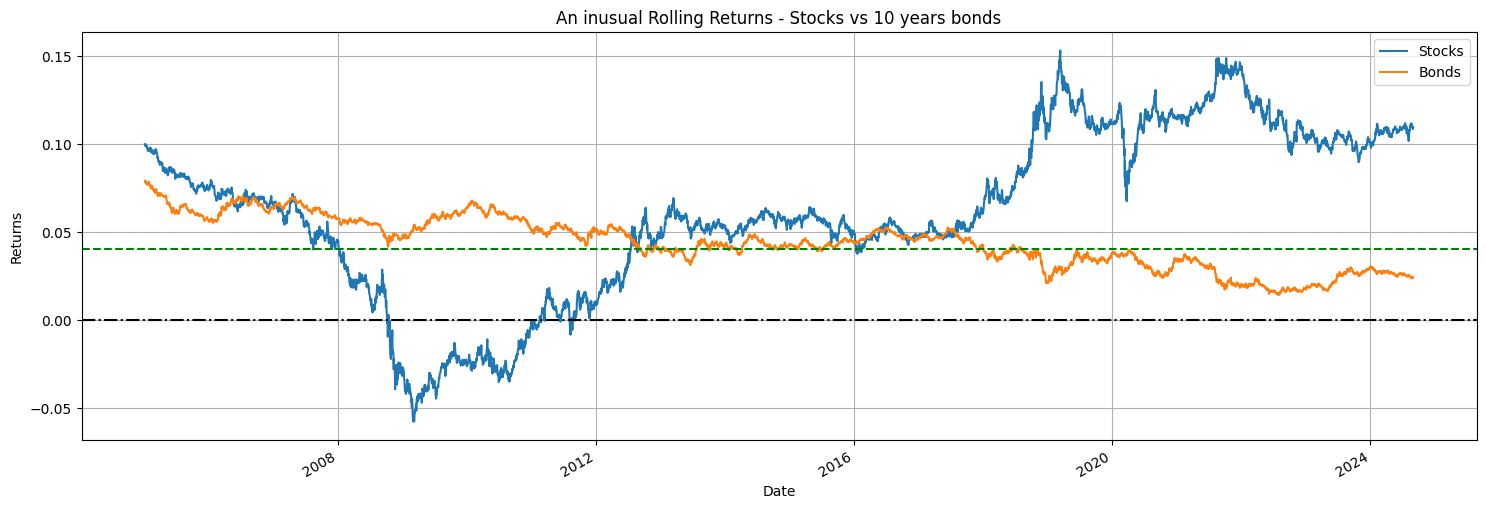

In [24]:
if use_matplot == True:
    fig = plt.figure()
    rendimenti_rolling.plot(figsize=(18,6))
    plt.title(f'An inusual Rolling Returns - Stocks vs {YEARS} years bonds')
    plt.axhline(0.04,ls='--',c='green')
    plt.axhline(0.00,ls='-.',c='black')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.grid()
    plt.show()
else:
    fig = px.line(
        data_frame=rendimenti_rolling,
        color_discrete_sequence=["#636EFA", "#EF553B", "#19D3F3", "#B6E880", "#FECB52", "#2ECB32","#FF6600","#0033CC"],
        template="plotly_dark",
    )
    fig.update_traces(hovertemplate=None)
    fig.update_layout(
        title=f'An inusual Rolling Returns - Stocks vs {YEARS} years bonds',
        yaxis_title="Returns",
        hovermode="x unified",
        legend_title='Asset'
    )
    fig.show()



<Axes: >

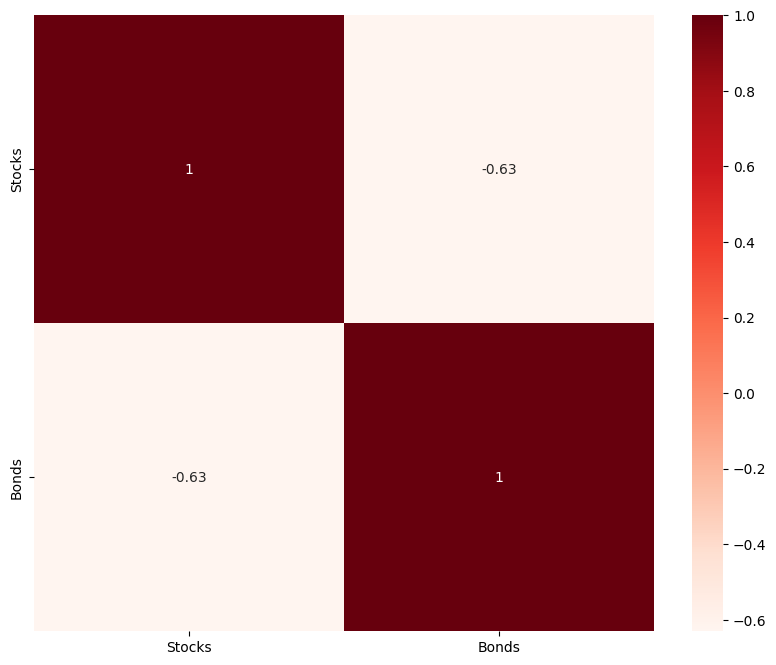

In [25]:
##VISUALIZZAZIONE DELLA CORRELAZIONE NEL PERIODO DI OSSERVAZIONE
plt.figure(figsize = (10,8))
#sns.heatmap(rendimenti.corr(),cmap="Reds", annot=True)
sns.heatmap(rendimenti_rolling.corr(),cmap="Reds", annot=True)

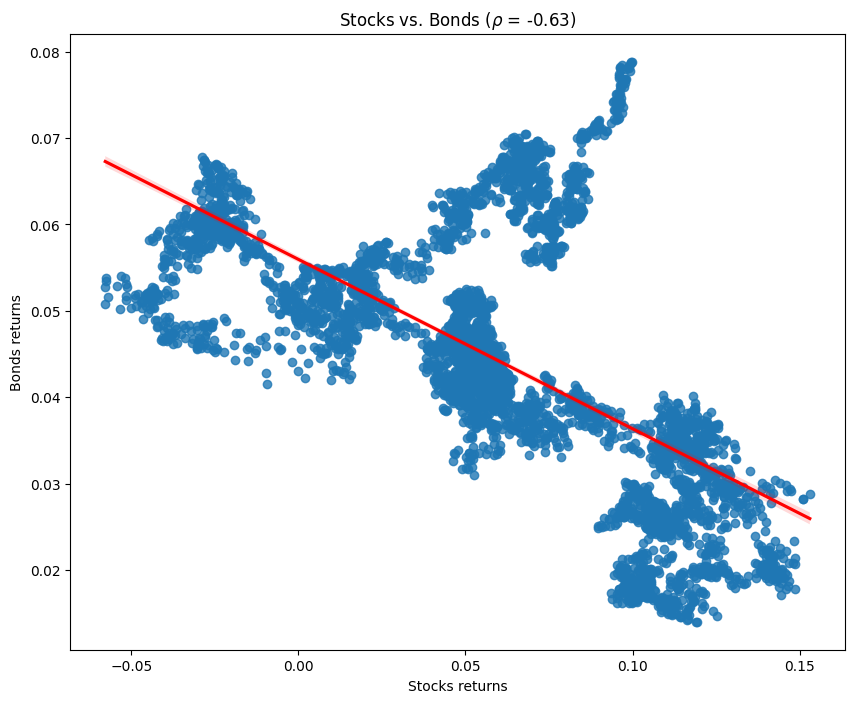

In [26]:
corr_coeff = rendimenti_rolling['Stocks'].corr(rendimenti_rolling['Bonds'])
plt.figure(figsize = (10,8))
ax = sns.regplot(x='Stocks', y='Bonds', data=rendimenti_rolling, line_kws={'color': 'red'})
ax.set(title=f'Stocks vs. Bonds ($\\rho$ = {corr_coeff:.2f})',
       ylabel='Bonds returns',
       xlabel='Stocks returns')

# plt.tight_layout()
# plt.savefig('images/ch1_im16.png')
plt.show()